# AILAB + LeNER-BR
This jupyter notebook is being develop to integrate the leNER-BR model described in this [article](https://cic.unb.br/~teodecampos/LeNER-Br/luz_etal_propor2018.pdf) with the AILAB text classification pipeline.  

In [1]:
from ailab_ner.lenerbr.ner_model import NERModel
from ailab_ner.lenerbr.config import Config
from ailab_ner.preprocessing import generate_freq_dist_plot, generate_wordcloud
import pandas as pd
from nltk import word_tokenize
from nltk import data
from nltk.tokenize.punkt import PunktSentenceTokenizer
import sys

## leNER-BR model

In [2]:
# create instance of config
config = Config()

# build model

model = NERModel(config)
model.build()
model.restore_session(config.dir_model)


From /home/dev/algoritmos/[AILAB]/leNER-Br/ailab_ner/lenerbr/ner_model.py:30: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


From /home/dev/algoritmos/[AILAB]/leNER-Br/ailab_ner/lenerbr/ner_model.py:110: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.


From /home/dev/algoritmos/[AILAB]/leNER-Br/ailab_ner/lenerbr/ner_model.py:130: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensor

### Constants

In [3]:
RELATIVE_PATH_TO_FOLDER = "./assets/datasets/"
RAW_DATA_FILENAME = "raw_data.parquet"
PROCESSED_DATA_FILENAME = "pre_processes.parquet"

## Loading raw data

In [4]:
excel_filename = RELATIVE_PATH_TO_FOLDER + RAW_DATA_FILENAME + ".gzip"
df_raw_data = pd.read_parquet(excel_filename)

print(df_raw_data.info())

0.4']
    $110.5 = $110.3 != $const110.4           ['$110.3', '$110.5', '$const110.4']
    branch $110.5, 122, 126                  ['$110.5']
label 122:
    $const122.1 = const(bool, False)         ['$const122.1']
    $122.2 = cast(value=$const122.1)         ['$122.2', '$const122.1']
    return $122.2                            ['$122.2']
label 126:
    $126.3 = old_itemsize // new_itemsize    ['$126.3', 'new_itemsize', 'old_itemsize']
    newdim = $126.3                          ['$126.3', 'newdim']
    $126.8 = getitem(value=dims, index=i)    ['$126.8', 'dims', 'i']
    $126.10 = inplace_binop(fn=<built-in function imul>, immutable_fn=<built-in function mul>, lhs=$126.8, rhs=newdim, static_lhs=Undefined, static_rhs=Undefined) ['$126.10', '$126.8', 'newdim']
    dims[i] = $126.10                        ['$126.10', 'dims', 'i']
    strides[i] = new_itemsize                ['i', 'new_itemsize', 'strides']
    jump 218                                 []
label 160:
    $160.3 = new_items

### Treating data

In [5]:
df_data = pd.DataFrame(data=df_raw_data['body'])

print(df_raw_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 273 to 15194
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_ocr           100 non-null    bool   
 1   body             100 non-null    object 
 2   text_extract     48 non-null     object 
 3   page_number      100 non-null    int64  
 4   document_id      100 non-null    int64  
 5   processes_id     100 non-null    int64  
 6   processes_class  100 non-null    object 
 7   piece_id         0 non-null      float64
 8   tema             100 non-null    int64  
 9   ordem            100 non-null    float64
 10  titulo           100 non-null    object 
 11  tipo             100 non-null    int64  
 12  data             100 non-null    float64
 13  origem           100 non-null    object 
 14  process_class    100 non-null    object 
dtypes: bool(1), float64(3), int64(5), object(6)
memory usage: 11.8+ KB
None


### Data Visualization

In [6]:
print(df_data.info())
print("Comprimento médio:", df_data['body'].str.len().mean())
print("Desvio padrão dos comprimentos das peças:", df_data['body'].str.len().std())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 273 to 15194
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    100 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB
None
Comprimento médio: 2104.45
Desvio padrão dos comprimentos das peças: 1272.8100890263531


### Listing entities types and preparing variables

In [7]:
TIPOS_ENTIDADES = ['PESSOA', 'TEMPO', 'LOCAL', 'ORGANIZACAO', 'JURISPRUDENCIA', 'LEGISLACAO']
entities_docs_per_sentence_per_type = dict()
person_docs, jurisprudence_docs, time_docs = [], [], []
legislation_docs, organizations_docs, localizations_docs = [], [], []
count_entidades = dict()
tokenizer = PunktSentenceTokenizer()

for tipo in TIPOS_ENTIDADES:
    count_entidades[tipo] = 0

docs = df_data['body'].values
tokenizer.train(docs)
print()

### Splicing documents sentences and tokenizing words

In [8]:
%%time
docs_tokenized = []
for doc in docs:
    entitities_in_doc = dict()
    doc_sentences = tokenizer.tokenize(doc)
    tokenized_sentences = []
    for sentence in doc_sentences:
        words = word_tokenize(sentence, language='portuguese')
        tokenized_sentences.append(words)
    docs_tokenized.append(tokenized_sentences)

print("Sentenças dividas em tokens")
print(docs_tokenized[0])

Sentenças dividas em tokens
[['REPÚBLICA', 'FEDERATIVA', 'DO', 'BRASIL', 'fls', '.'], ['46', 'Livro', '2784', 'CARTÓRIO', 'DO', '5°', 'OFÍCIO', 'DE', 'NOTAS', 'Este', 'documento', 'é', 'cópia', 'do', 'original', ',', 'assinado', 'digitalmente', 'por', 'ULISSES', 'FUNAKAWA', 'DE', 'SOUZA', 'e', 'Tribunal', 'de', 'Justica', 'do', 'Estado', 'de', 'Sao', 'Paulo', ',', 'protocolado', 'em', '28/02/2018', 'às', '11:44', ',', 'sob', 'o', 'número', '20339547620188260000', '.'], ['DE', 'TAGUATINGA', '-', 'DF', 'FLS', '170', 'Ronaldo', 'Ribeiro', 'de', 'Faria', '-', 'Tabelião', 'QNA', '04-', 'LOTES', '32/34', '(', 'PRAÇA', 'DO', 'DI', ')', '-', 'TAGUATINGA', '-', 'DF', '-', 'CEP', '72110-040', 'Prot', ':', '735909', 'FONE', ':', '(', '61', ')', '3961.8900', '/', '3351-8787', '-', 'FAX', ':', '(', '61', ')', '3351-6992', 'Site', ':', 'www.cartoriodenotasdf.com.br', '-', 'email', ':', 'cartorio5df', '@', 'grnailcom', 'tstr.z.', ',', 'P', 'R', 'OCU', 'RAÇÃO', 'bastante', 'que', 'faz', '(', 'em', ')'

### Using model to identify entities

In [9]:
%%time
docs_labels = []
for doc in docs_tokenized:
    entitities_in_doc = dict()
    label_doc = []
    for token_sentence in doc:
        preds = model.predict(token_sentence)
        label_doc.append(preds)
        for i, word in enumerate(token_sentence):
            ''' Removendo sufixo de tipo de entidades'''
            if preds[i][0:2] in ['B-', 'I-', 'E-', 'S-']:
                preds[i] = preds[i][2:]
            if preds[i] != 'O':
                ent_type = preds[i]
                count_entidades[ent_type] += 1
                if ent_type not in entitities_in_doc.keys():
                    entitities_in_doc[ent_type] = [word]
                else:
                    entitities_in_doc[ent_type].append(word)
        
    ''' Separando cada bolsa de palavras por tipo de entididade '''
    if 'PESSOA' in entitities_in_doc.keys():
        person_docs.append(" ".join(entitities_in_doc['PESSOA']))
    else:
        person_docs.append(" ")

    if 'JURISPRUDENCIA'  in entitities_in_doc.keys():
        jurisprudence_docs.append(" ".join(entitities_in_doc['JURISPRUDENCIA']))
    else:
        jurisprudence_docs.append(" ")

    if 'TEMPO' in entitities_in_doc.keys():
        time_docs.append(" ".join(entitities_in_doc['TEMPO']))
    else:
        time_docs.append(" ")

    if 'LEGISLACAO'  in entitities_in_doc.keys():
        legislation_docs.append(" ".join(entitities_in_doc['LEGISLACAO']))
    else:
        legislation_docs.append(" ")

    if 'ORGANIZACAO'  in entitities_in_doc.keys():
        organizations_docs.append(" ".join(entitities_in_doc['ORGANIZACAO']))
    else:
        organizations_docs.append(" ")

    if 'LOCAL'  in entitities_in_doc.keys():
        localizations_docs.append(" ".join(entitities_in_doc['LOCAL']))
    else:
        localizations_docs.append(" ")

    docs_labels.append(label_doc)
print("Identificação de entidades")

Identificação de entidades
CPU times: user 19.3 s, sys: 671 ms, total: 20 s
Wall time: 8.6 s


### Printing text with entities

In [10]:
bcolors = {
    "PESSOA": '\033[94m',
    "TEMPO": '\033[92m',
    "LOCAL": '\033[93m',
    "ORGANIZACAO": '\033[91m',
    "JURISPRUDENCIA": '\033[35m',
    "LEGISLACAO": '\033[36m',
    "ENDC": '\033[0m',
    "O": ""
}

for entities_sentences, sentences in zip(docs_labels[:2], docs_tokenized[:2]):
    for preds, sentence in zip(entities_sentences[:100], sentences[:100]):
        for index, word in enumerate(sentence):
            print(bcolors[preds[index]] +
                word + bcolors["ENDC"], end=' ')
        print()
    print()

REPÚBLICA FEDERATIVA DO BRASIL fls . 
46 Livro 2784 CARTÓRIO DO 5° OFÍCIO DE NOTAS Este documento é cópia do original , assinado digitalmente por ULISSES FUNAKAWA DE SOUZA e Tribunal de Justica do Estado de Sao Paulo , protocolado em 28/02/2018 às 11:44 , sob o número 20339547620188260000 . 
DE TAGUATINGA - DF FLS 170 Ronaldo Ribeiro de Faria - Tabelião QNA 04- LOTES 32/34 ( PRAÇA DO DI ) - TAGUATINGA - DF - CEP 72110-040 Prot : 735909 FONE : ( 61 ) 3961.8900 / 3351-8787 - FAX : ( 61 ) 3351-6992 Site : www.cartoriodenotasdf.com.br - email : cartorio5df @ grnailcom tstr.z. , P R OCU RAÇÃO bastante que faz ( em ) : BANCO DO BRASIL S.A. , '42.fejr›.5 ' Aos vinte e dois dias do mês de fevereiro do ano de dois mil e dezessete ( 22/0 2 /2 017 ) , nesta cidade de Taguatinga , Distrito Federal . 
em Cartório , lavro este instrumento público , em que , comparece ( m ) como outorgante ( s ) , BANCO DO BRASIL S.A.. sociedade de economia mista , sediado no Setor de Autarquias Norte . 
Quadra 05 . 

### Replacing Entities with tokens

In [11]:
''' Let's first take a look on what the result would be '''
for entities_sentences, sentences in zip(docs_labels[:2], docs_tokenized[:2]):
    for preds, sentence in zip(entities_sentences[:100], sentences[:100]):
        for index, word in enumerate(sentence):
            if preds[index] == 'PESSOA':
                print('PESSOA_IDENTIFICADA', end=' ')
            elif preds[index] == 'LOCALIDADE':
                print('LOCALIDADE_IDENTIFICADA', end=' ')
            else:
                print(word, end=' ')
        print()
    print()

''' Now let's replace those tokens '''
replaced_docs_text = []
for entities_sentences, sentences in zip(docs_labels, docs_tokenized):
    replaced_sentences = []
    for preds, sentence in zip(entities_sentences[:100], sentences[:100]):
        for index, word in enumerate(sentence):
            if preds[index] == 'PESSOA':
                replaced_sentences.append('PESSOA_IDENTIFICADA')
            elif preds[index] == 'LOCAl':
                replaced_sentences.append('LOCALIDADE_IDENTIFICADA')
            else:
                replaced_sentences.append(word)
    replaced_docs_text.append(" ".join(replaced_sentences))
print(replaced_docs_text[0])

REPÚBLICA FEDERATIVA DO BRASIL fls . 
46 Livro 2784 CARTÓRIO DO 5° OFÍCIO DE NOTAS Este documento é cópia do original , assinado digitalmente por PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA e Tribunal de Justica do Estado de Sao Paulo , protocolado em 28/02/2018 às 11:44 , sob o número 20339547620188260000 . 
DE TAGUATINGA - DF FLS 170 Ronaldo PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA - Tabelião QNA 04- LOTES 32/34 ( PRAÇA DO DI ) - TAGUATINGA - DF - CEP 72110-040 Prot : 735909 FONE : ( 61 ) 3961.8900 / 3351-8787 - FAX : ( 61 ) 3351-6992 Site : www.cartoriodenotasdf.com.br - email : cartorio5df @ grnailcom tstr.z. , P R OCU RAÇÃO bastante que faz ( em ) : BANCO DO BRASIL S.A. , '42.fejr›.5 ' Aos vinte e dois dias do mês de fevereiro do ano de dois mil e dezessete ( 22/0 2 /2 017 ) , nesta cidade de Taguatinga , Distrito Federal . 
em Cartório , lavro este instrumento público , em que , comparece ( m ) como outorgante ( s ) , BANCO D

## Analysing entities found

In [12]:
df_data['PESSOA'] = person_docs
df_data['TEMPO'] = time_docs
df_data['LOCAL'] = localizations_docs
df_data['ORGANIZACAO'] = organizations_docs
df_data['JURISPRUDENCIA'] = jurisprudence_docs
df_data['LEGISLACAO'] = legislation_docs
df_data['REPLACED_DOC'] = replaced_docs_text

In [13]:
for tipo in TIPOS_ENTIDADES:
    print("Quantidade de entidades encontradas do tipo: " + tipo + " - " + str(count_entidades[tipo]))

Quantidade de entidades encontradas do tipo: PESSOA - 2627
Quantidade de entidades encontradas do tipo: TEMPO - 446
Quantidade de entidades encontradas do tipo: LOCAL - 1139
Quantidade de entidades encontradas do tipo: ORGANIZACAO - 1121
Quantidade de entidades encontradas do tipo: JURISPRUDENCIA - 289
Quantidade de entidades encontradas do tipo: LEGISLACAO - 623


iberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Arial' (Arial_Bold.ttf) normal normal bold normal>) = 6.698636363636363
findfont: score(<Font 'Gubbi' (Gubbi.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Khmer OS System' (KhmerOSsys.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
findfont: score(<Font 'Sarai' (Sarai.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 7.413636363636363
findfont: score(<Font 'Vemana2000' (vemana2000.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
findfont: score(<Font 'Ubuntu Condensed' (Ubun

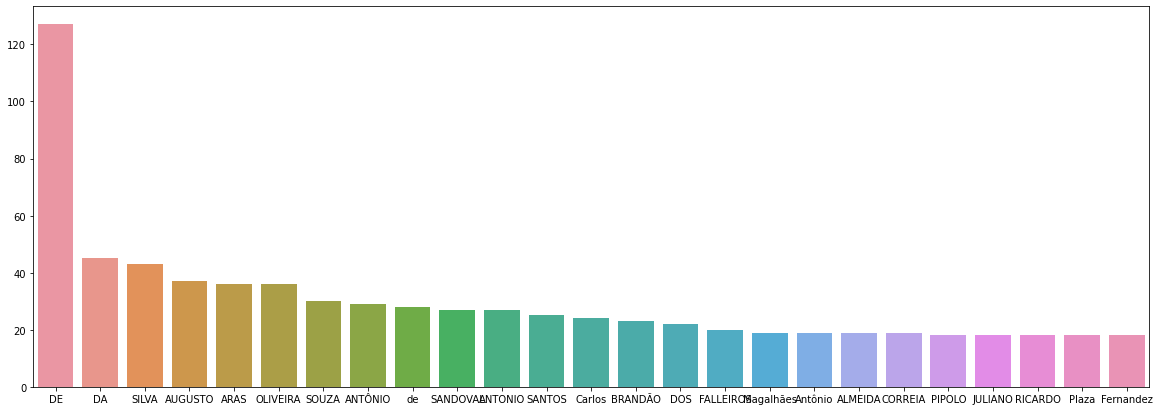

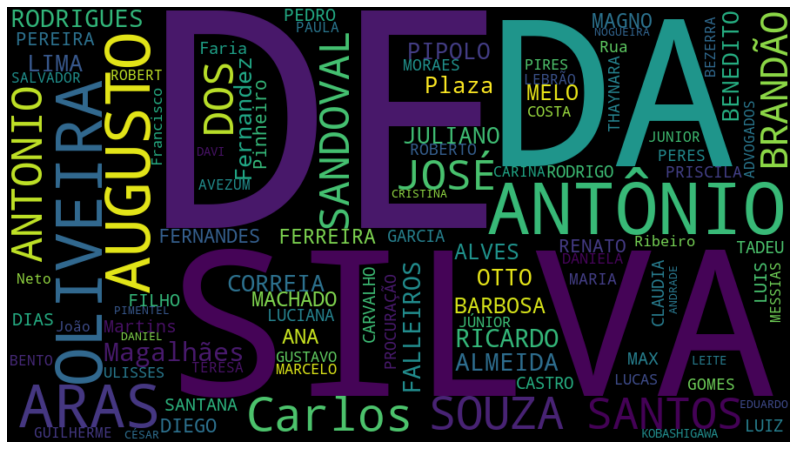

Entidades do tipo: TEMPO
de           104
/             89
2017          23
6973          18
2014          18
2018          16
2013          13
29            12
03            11
2016          11
.             11
04            10
09             9
02             9
20             7
11             7
08             7
14             7
12             7
2015           6
22             6
setembro       6
fevereiro      6
agosto         5
-              5
dtype: int64


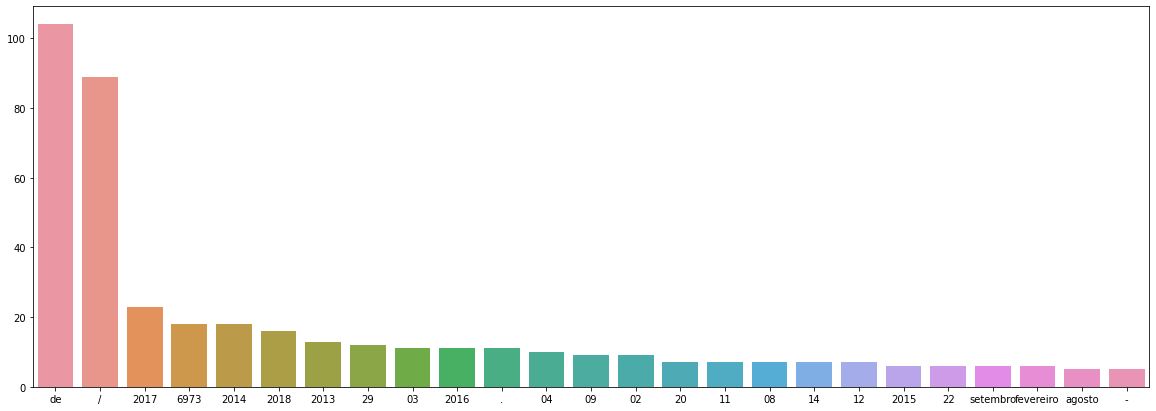

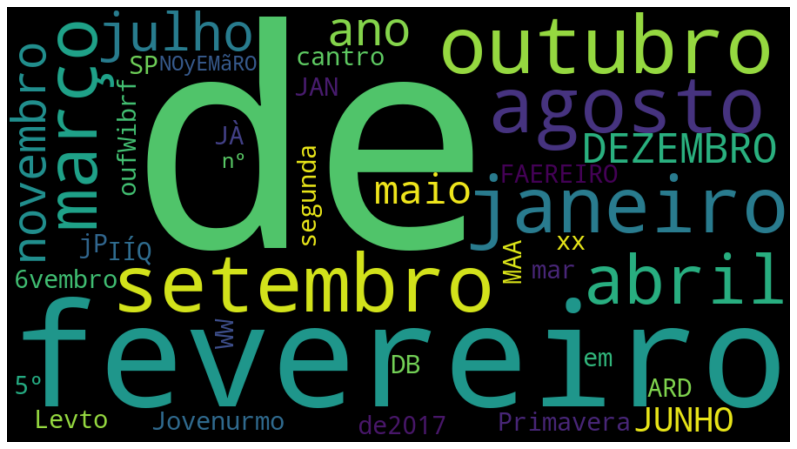

Entidades do tipo: LOCAL
Rua          70
São          56
/            55
de           47
Brasil       45
Paulo        44
SP           37
-            33
Salvador     32
Bairro       21
DF           21
Rio          20
Bahia        18
Estado       17
Centro       17
Brasília     15
SC           15
MG           13
Jardim       12
Cidade       11
do           11
.            11
Janeiro      11
Horizonte    10
Belo         10
dtype: int64


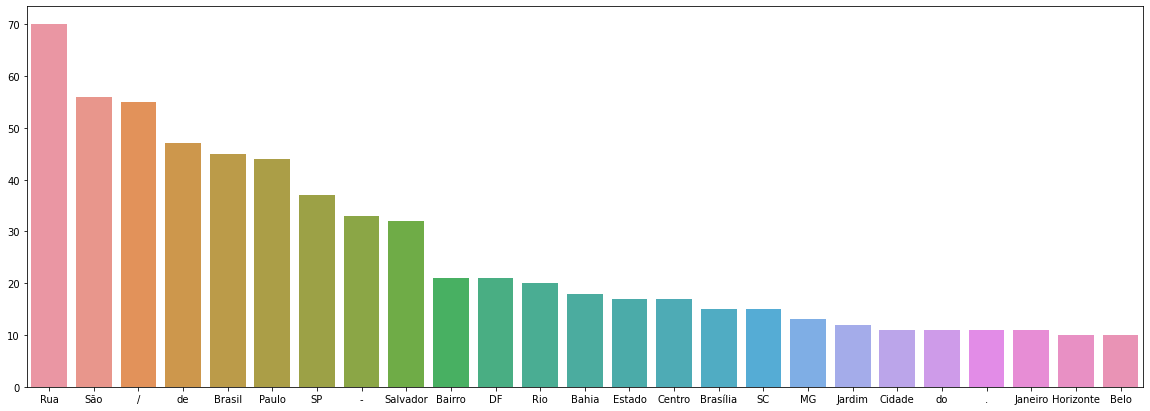

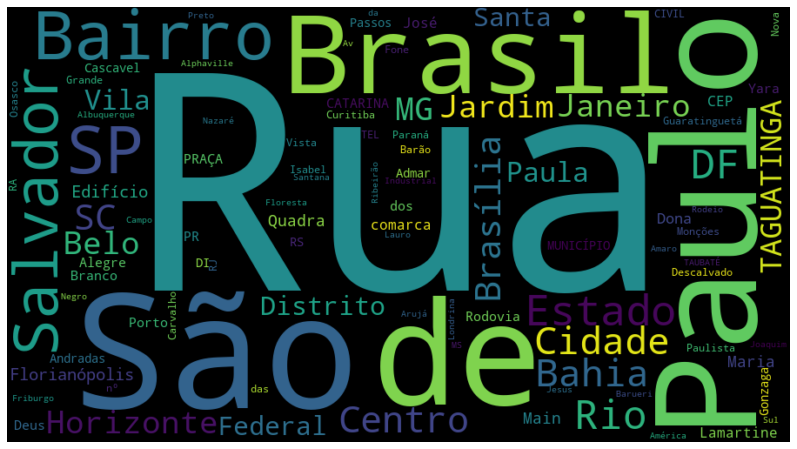

Entidades do tipo: ORGANIZACAO
do             83
Federal        45
de             44
da             37
Estado         33
Distrito       30
DE             29
.              28
Seção          28
Brasil         22
DO             20
São            19
A              18
Bahia          18
S              18
Banco          17
Paulo          16
BRASIL         14
Norte          14
CAIXA          13
FEDERAL        13
Empresarial    12
Centro         12
BANCO          11
ESTADO         11
dtype: int64


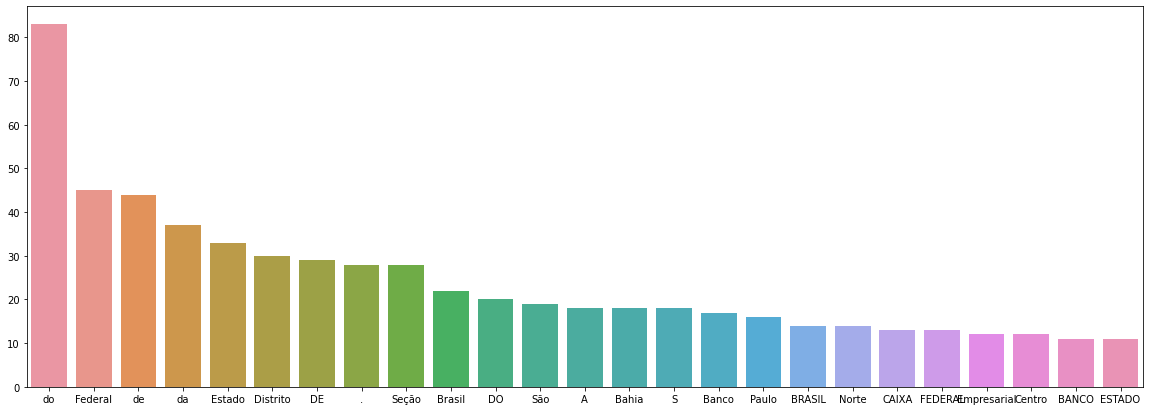

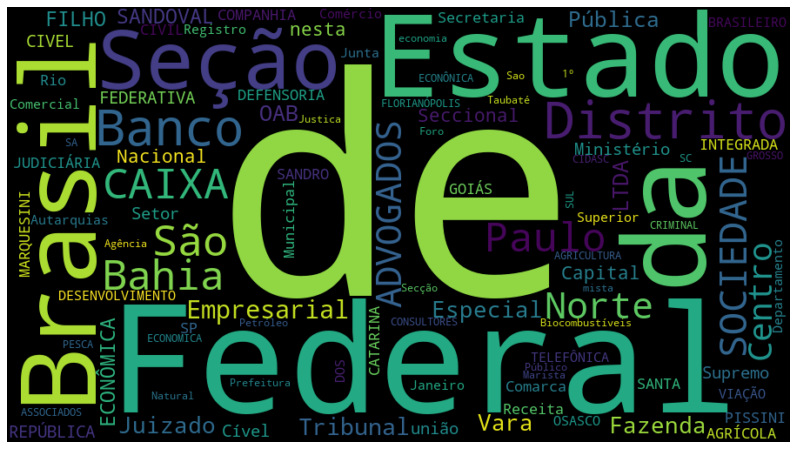

Entidades do tipo: JURISPRUDENCIA
.       155
/        85
OAB      66
SP       60
nº       31
-        28
sob      10
RG        7
300       7
n         7
022       7
1         6
8         6
,         6
4         6
RJ        6
298       5
º         5
SC        4
2015      4
04        4
Ação      3
Nº        3
7200      3
16        3
dtype: int64


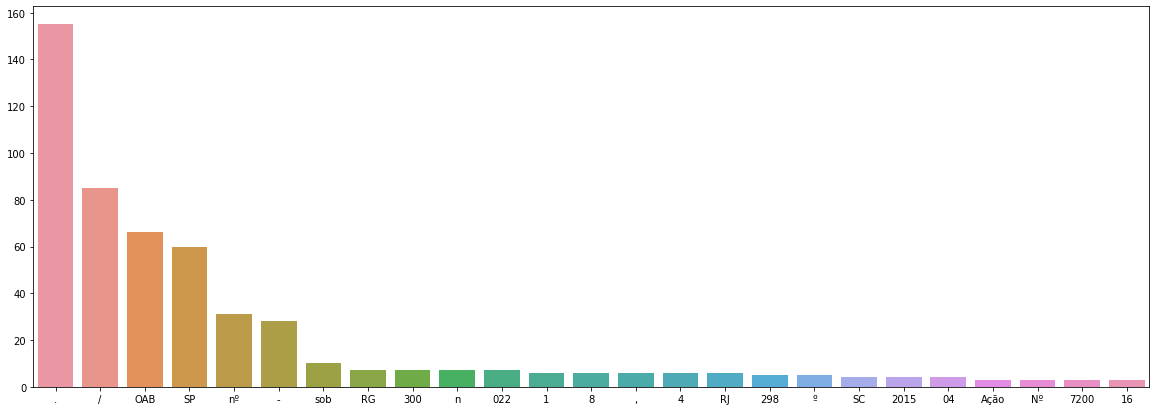

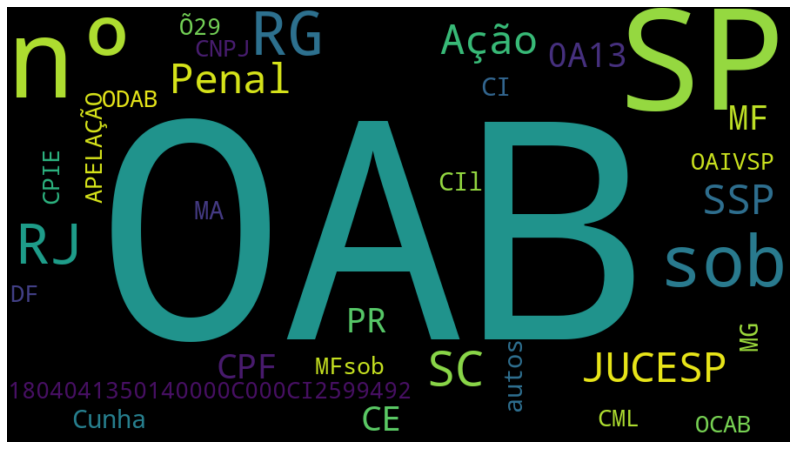

Entidades do tipo: LEGISLACAO
.           185
/            75
nº           69
n            52
-            43
º            35
do           26
OAB          23
,            23
sob          21
MF           19
artigo       18
Lei          16
CPF          14
SP           12
30           10
RG           10
810           9
e             8
código        8
de            7
38E8E1C       7
Estatuto      7
Processo      7
CPC           7
dtype: int64


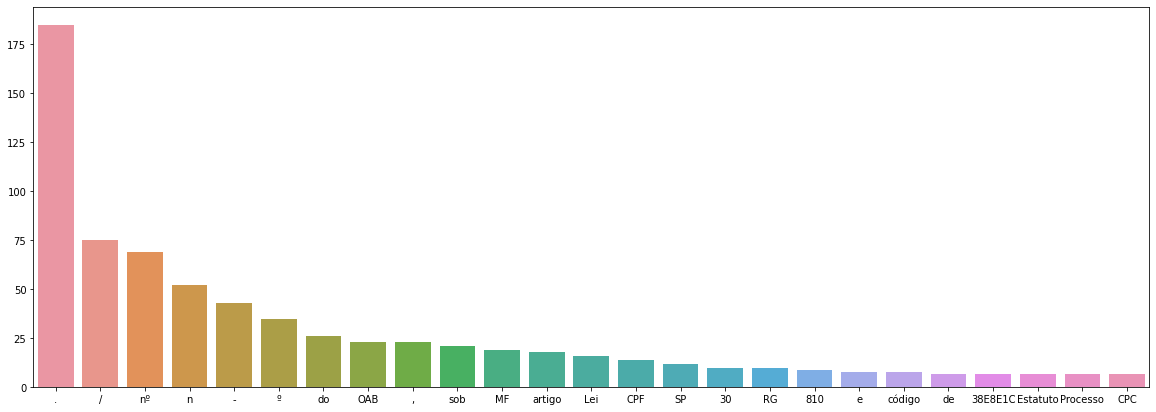

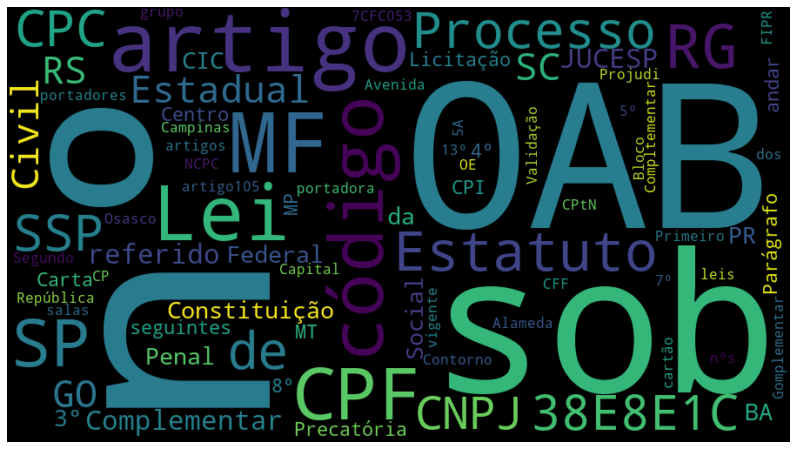

In [14]:
for column in TIPOS_ENTIDADES:
    if count_entidades[column] < 1:
        continue
    print("Entidades do tipo: " + column)
    print(generate_freq_dist_plot(df_data[column]))
    generate_wordcloud(df_data[column])

### Storing entities found

In [15]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + RAW_DATA_FILENAME + "_treated.xlsx"

In [16]:
"""  Convert the dataframe to an xlsx file """
df_data.to_excel(excel_filename)

print("Stored tread dataset on ", excel_filename)

Stored tread dataset on  ./assets/datasets/raw_data.parquet_treated.xlsx


## Same pipeline for processed data
### Loading and Treating Data

In [17]:
excel_filename = RELATIVE_PATH_TO_FOLDER + PROCESSED_DATA_FILENAME + ".gzip"
df_processed_data = pd.read_parquet(excel_filename)

print(df_processed_data.info())

df_data = pd.DataFrame(data=df_processed_data['text'])

print(df_processed_data.info())
print("Comprimento médio:", df_data['text'].str.len().mean())
print("Desvio padrão dos comprimentos das peças:", df_data['text'].str.len().std())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 273 to 15194
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_ocr           100 non-null    bool   
 1   page_number      100 non-null    int64  
 2   document_id      100 non-null    int64  
 3   processes_id     100 non-null    int64  
 4   processes_class  100 non-null    object 
 5   tema             100 non-null    int64  
 6   ordem            100 non-null    float64
 7   titulo           100 non-null    object 
 8   tipo             100 non-null    int64  
 9   data             100 non-null    float64
 10  origem           100 non-null    object 
 11  process_class    100 non-null    object 
 12  is_text_extract  100 non-null    bool   
 13  text             100 non-null    object 
 14  topic            100 non-null    int64  
 15  sim              100 non-null    float64
 16  out              100 non-null    int64  
 17  clusters    

### Tokenizing Text Variable and counting entities

In [18]:
%%time
TIPOS_ENTIDADES = ['PESSOA', 'TEMPO', 'LOCAL', 'ORGANIZACAO', 'JURISPRUDENCIA', 'LEGISLACAO']
entities_docs_per_sentence_per_type = dict()
person_docs, jurisprudence_docs, time_docs = [], [], []
legislation_docs, organizations_docs, localizations_docs = [], [], []
count_entidades = dict()
tokenizer = PunktSentenceTokenizer()

for tipo in TIPOS_ENTIDADES:
    count_entidades[tipo] = 0

docs = df_data['text'].values
tokenizer.train(docs)
print()


docs_tokenized = []
for doc in docs:
    entitities_in_doc = dict()
    doc_sentences = tokenizer.tokenize(doc)
    tokenized_sentences = []
    for sentence in doc_sentences:
        words = word_tokenize(sentence, language='portuguese')
        tokenized_sentences.append(words)
    docs_tokenized.append(tokenized_sentences)



CPU times: user 193 ms, sys: 143 µs, total: 193 ms
Wall time: 198 ms


In [19]:
%%time
docs_labels = []
for doc in docs_tokenized:
    entitities_in_doc = dict()
    label_doc = []
    for token_sentence in doc:
        preds = model.predict(token_sentence)
        label_doc.append(preds)
        for i, word in enumerate(token_sentence):
            ''' Removendo sufixo de tipo de entidades'''
            if preds[i][0:2] in ['B-', 'I-', 'E-', 'S-']:
                preds[i] = preds[i][2:]
            if preds[i] != 'O':
                ent_type = preds[i]
                count_entidades[ent_type] += 1
                if ent_type not in entitities_in_doc.keys():
                    entitities_in_doc[ent_type] = [word]
                else:
                    entitities_in_doc[ent_type].append(word)
        
    ''' Separando cada bolsa de palavras por tipo de entididade '''
    if 'PESSOA' in entitities_in_doc.keys():
        person_docs.append(" ".join(entitities_in_doc['PESSOA']))
    else:
        person_docs.append(" ")

    if 'JURISPRUDENCIA'  in entitities_in_doc.keys():
        jurisprudence_docs.append(" ".join(entitities_in_doc['JURISPRUDENCIA']))
    else:
        jurisprudence_docs.append(" ")

    if 'TEMPO' in entitities_in_doc.keys():
        time_docs.append(" ".join(entitities_in_doc['TEMPO']))
    else:
        time_docs.append(" ")

    if 'LEGISLACAO'  in entitities_in_doc.keys():
        legislation_docs.append(" ".join(entitities_in_doc['LEGISLACAO']))
    else:
        legislation_docs.append(" ")

    if 'ORGANIZACAO'  in entitities_in_doc.keys():
        organizations_docs.append(" ".join(entitities_in_doc['ORGANIZACAO']))
    else:
        organizations_docs.append(" ")

    if 'LOCAL'  in entitities_in_doc.keys():
        localizations_docs.append(" ".join(entitities_in_doc['LOCAL']))
    else:
        localizations_docs.append(" ")

    docs_labels.append(label_doc)
print("Identificação de entidades")

Identificação de entidades
CPU times: user 7.1 s, sys: 250 ms, total: 7.35 s
Wall time: 3.9 s


In [20]:
bcolors = {
    "PESSOA": '\033[94m',
    "TEMPO": '\033[92m',
    "LOCAL": '\033[93m',
    "ORGANIZACAO": '\033[91m',
    "JURISPRUDENCIA": '\033[35m',
    "LEGISLACAO": '\033[36m',
    "ENDC": '\033[0m',
    "O": ""
}

for entities_sentences, sentences in zip(docs_labels[:2], docs_tokenized[:2]):
    for preds, sentence in zip(entities_sentences[:100], sentences[:100]):
        for index, word in enumerate(sentence):
            print(bcolors[preds[index]] +
                word + bcolors["ENDC"], end=' ')
        print()
    print()

republica federativa brasil fales livro cartorio oficio notas documento copia original assinado digitalmente ulisses souza tribunal justifica estado saio paulo protocolado sob numero fales ronaldo ribeiro faria tabeliao quina lotes prata dei cepo pronta fone fax site ema tst ocupe rajo bastante brasil vinte dois dias mes fevereiro ano dois mil dezessete nesta cidade LOCALIDADE cartorio lavro instrumento publico comparecem outorgastes banco brasil sociedade economia mista sediado setor autarquias norte quadra lote torre andar edificio banco brasil LOCALIDADE LOCALIDADE inscrito cpmf sob numero atos constitutivos registrados arquivados departamento nacional registro comercio sob neste ato representado forma prevista ST_ARTIGO_27 estatuto diretor juridico antonio pedro silva machado brasileiro divorciado advogado inscrito oab sob oab portador carteira identidade cpi residente nesta capital domiciliado sede empresa investido funcao conforme decisao conselho administracao banco brasil reuni

In [21]:
''' Let's first take a look on what the result would be '''
for entities_sentences, sentences in zip(docs_labels[:2], docs_tokenized[:2]):
    for preds, sentence in zip(entities_sentences[:100], sentences[:100]):
        for index, word in enumerate(sentence):
            if preds[index] == 'PESSOA':
                print('PESSOA_IDENTIFICADA', end=' ')
            elif preds[index] == 'LOCALIDADE':
                print('LOCALIDADE_IDENTIFICADA', end=' ')
            else:
                print(word, end=' ')
        print()
    print()

''' Now let's replace those tokens '''
replaced_docs_text = []
for entities_sentences, sentences in zip(docs_labels, docs_tokenized):
    replaced_sentences = []
    for preds, sentence in zip(entities_sentences[:100], sentences[:100]):
        for index, word in enumerate(sentence):
            if preds[index] == 'PESSOA':
                replaced_sentences.append('PESSOA_IDENTIFICADA')
            elif preds[index] == 'LOCAl':
                replaced_sentences.append('LOCALIDADE_IDENTIFICADA')
            else:
                replaced_sentences.append(word)
    replaced_docs_text.append(" ".join(replaced_sentences))

republica federativa brasil fales livro cartorio oficio notas documento copia original assinado digitalmente PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA tribunal justifica estado saio paulo protocolado sob numero fales ronaldo PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA tabeliao quina lotes prata dei cepo pronta fone fax site ema tst ocupe rajo bastante brasil vinte dois dias mes fevereiro ano dois mil dezessete nesta cidade LOCALIDADE cartorio lavro instrumento publico comparecem outorgastes banco brasil sociedade economia mista sediado setor autarquias norte quadra lote torre andar edificio banco brasil LOCALIDADE LOCALIDADE inscrito cpmf sob numero atos constitutivos registrados arquivados departamento nacional registro comercio sob neste ato representado forma prevista ST_ARTIGO_27 estatuto diretor juridico PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA PESSOA_IDENTIFICADA divorciado advogado inscrito oab sob oab portador carteira identidade cpi residente n

### Analysing and Storing

Quantidade de entidades encontradas do tipo: PESSOA - 1230
Quantidade de entidades encontradas do tipo: TEMPO - 52
Quantidade de entidades encontradas do tipo: LOCAL - 181
Quantidade de entidades encontradas do tipo: ORGANIZACAO - 378
Quantidade de entidades encontradas do tipo: JURISPRUDENCIA - 0
Quantidade de entidades encontradas do tipo: LEGISLACAO - 0
Entidades do tipo: PESSOA
brasileiro    91
brasileira    77
antonio       76
silva         67
oliveira      42
augusto       37
souza         31
carlos        30
lima          20
santos        19
correia       19
almeida       19
aras          18
junior        17
rodrigues     17
barbosa       16
ana           16
alves         16
machado       15
magno         14
ferreira      13
martins       11
LOCALIDADE    11
pinheiro      11
santana       10
dtype: int64


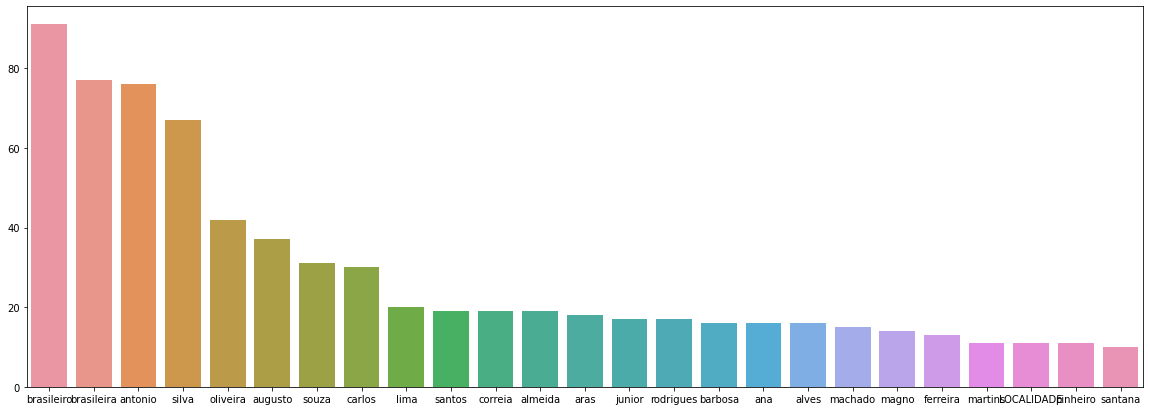

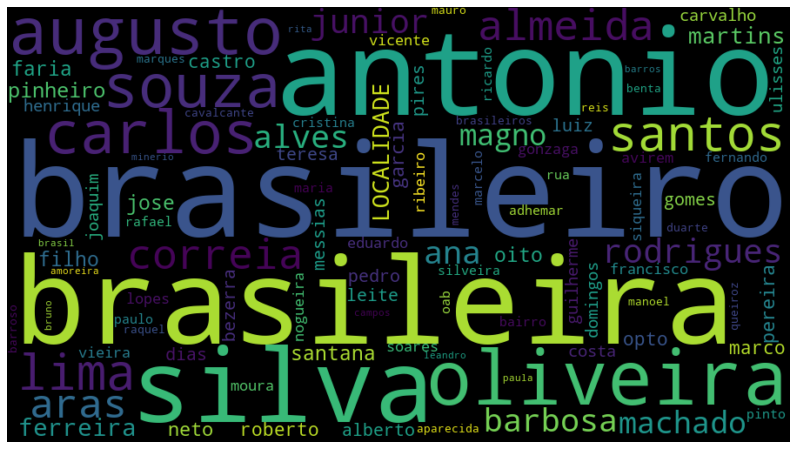

Entidades do tipo: TEMPO
janeiro       7
fevereiro     6
outubro       5
ano           5
julho         4
abril         4
novembro      4
setembro      4
agosto        3
segunda       2
brasileiro    2
dezembro      1
quarta        1
rio           1
maio          1
junho         1
registrada    1
dtype: int64


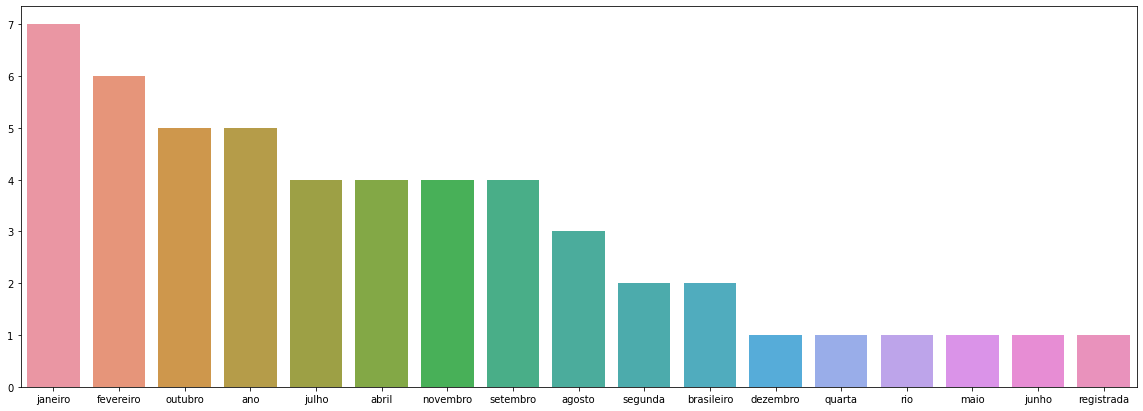

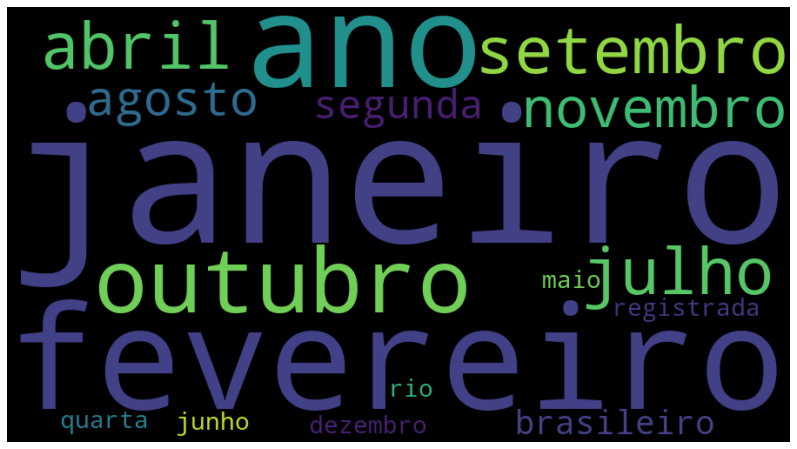

Entidades do tipo: LOCAL
paulo          17
rio            16
estado         16
bairro         15
janeiro        15
LOCALIDADE     13
rua            10
centro         10
vila            4
jardim          4
brasil          4
cidade          4
comarca         3
ara             3
cascavel        2
agosto          2
santana         2
setembro        2
brasileira      2
santa           2
LOCALIDADEs     2
aradas          2
sul             2
parque          1
campos          1
dtype: int64


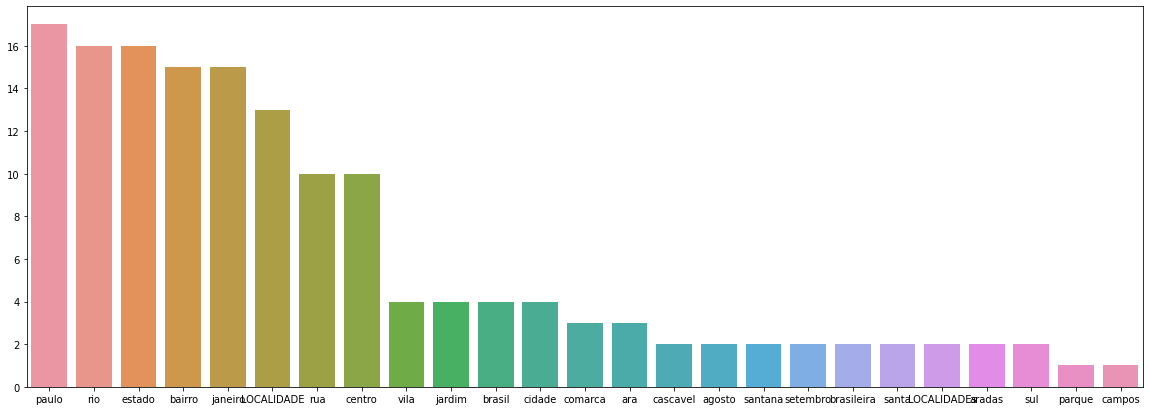

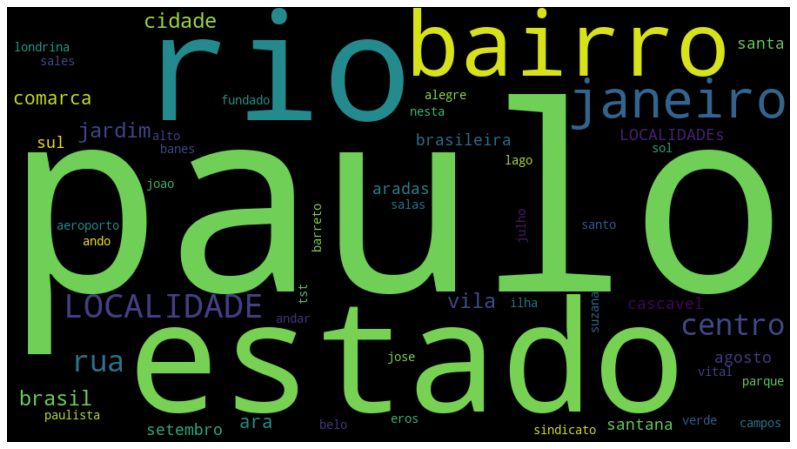

Entidades do tipo: ORGANIZACAO
oab                263
brasil              16
banco               15
LOCALIDADE          15
tribunal             6
federal              5
supremo              5
brasileiro           4
sociedade            4
sediado              4
setor                4
economia             4
mista                4
norte                3
stf                  3
autarquias           3
estado               3
civil                2
tst                  2
inss                 2
LOCALIDADEscimo      1
nacional             1
stj                  1
cidade               1
londrina             1
dtype: int64


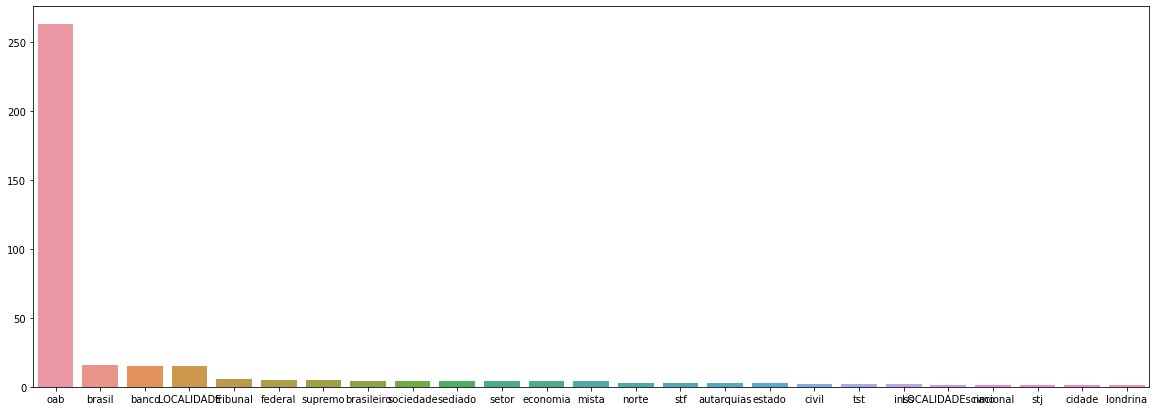

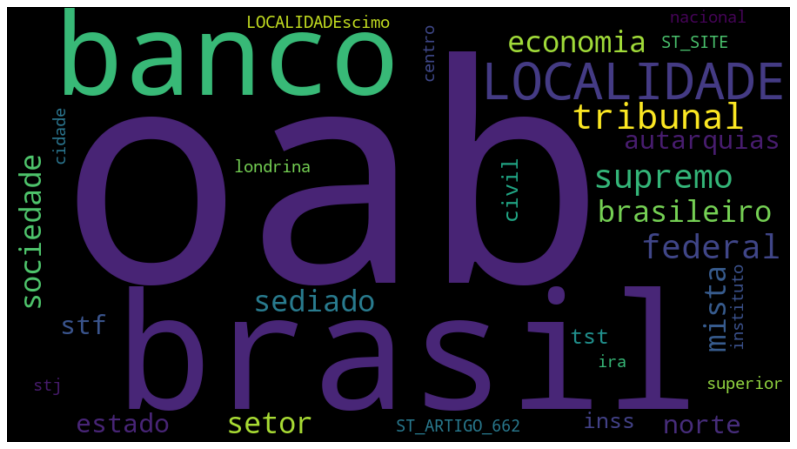

In [24]:
df_data['PESSOA'] = person_docs
df_data['TEMPO'] = time_docs
df_data['LOCAL'] = localizations_docs
df_data['ORGANIZACAO'] = organizations_docs
df_data['JURISPRUDENCIA'] = jurisprudence_docs
df_data['LEGISLACAO'] = legislation_docs
df_data['REPLACED_DOC'] = replaced_docs_text

for tipo in TIPOS_ENTIDADES:
    print("Quantidade de entidades encontradas do tipo: " + tipo + " - " + str(count_entidades[tipo]))
    
for column in TIPOS_ENTIDADES:
    if count_entidades[column] < 1:
        continue
    print("Entidades do tipo: " + column)
    print(generate_freq_dist_plot(df_data[column]))
    generate_wordcloud(df_data[column])

In [23]:
"""  Let"s store the data """
excel_filename = RELATIVE_PATH_TO_FOLDER + PROCESSED_DATA_FILENAME + "_treated.xlsx"

"""  Convert the dataframe to an xlsx file """
df_data.to_excel(excel_filename)

print("Stored tread dataset on ", excel_filename)

Stored tread dataset on  ./assets/datasets/pre_processes.parquet_treated.xlsx
